# libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import os
import random
import json
from collections import defaultdict, OrderedDict
import shutil
from math import *

# utils

In [2]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def rmse(x_pred, x_target, reduce=True):
    if reduce:
        return x_pred.sub(x_target).pow(2).sum(-1).sqrt().mean().item()
    return x_pred.sub(x_target).pow(2).sum(-1).sqrt().squeeze()


def identity(input):
    return input


In [3]:
class MLP(nn.Module):
    def __init__(self, ninp, nhid, nout, nlayers, dropout):
        super(MLP, self).__init__()
        self.ninp = ninp
        # modules
        if nlayers == 1:
            self.module = nn.Linear(ninp, nout)
        else:
            modules = [nn.Linear(ninp, nhid), nn.ReLU(), nn.Dropout(dropout)]
            nlayers -= 1
            while nlayers > 1:
                modules += [nn.Linear(nhid, nhid), nn.ReLU(), nn.Dropout(dropout)]
                nlayers -= 1
            modules.append(nn.Linear(nhid, nout))
            self.module = nn.Sequential(*modules)

    def forward(self, input):
        return self.module(input)


In [4]:
class Logger(object):
    def __init__(self, log_dir, name, chkpt_interval):
        super(Logger, self).__init__()
        os.makedirs(os.path.join(log_dir, name))
        self.log_path = os.path.join(log_dir, name, 'logs.json')
        self.model_path = os.path.join(log_dir, name, 'model.pt')
        self.logs = defaultdict(list)
        self.logs['epoch'] = 0
        self.chkpt_interval = chkpt_interval

    def log(self, key, value):
        if isinstance(value, dict):
            for k, v in value.items():
                self.log('{}.{}'.format(key, k), v)
        else:
            self.logs[key].append(value)

    def checkpoint(self, model):
        if (self.logs['epoch'] + 1) % self.chkpt_interval == 0:
            self.save(model)
        self.logs['epoch'] += 1

    def save(self, model):
        with open(self.log_path, 'w') as f:
            json.dump(self.logs, f, sort_keys=True, indent=4)
        torch.save(model.state_dict(), self.model_path)

# Model

In [5]:

class DFG(nn.Module):
    def __init__(self, nx, nt, nz, pz = 3, nhid=0, nlayers=1,
                 activation='identity', device='cuda'):
        super(DFG, self).__init__()
        assert (nhid > 0 and nlayers > 1) or (nhid == 0 and nlayers == 1)
        # attributes
        self.nt = nt
        self.nx = nx
        self.nz = nz
        self.pz = pz

        # kernel
        self.activation = torch.tanh if activation == 'tanh' else identity if activation == 'identity' else None
        
        # modules
        self.factors = nn.Parameter(torch.Tensor(nt, nz))
        self.dynamic = MLP(pz*nz, nhid, nz, nlayers, 0)
        self.decoder = nn.Linear(nz, nx, bias=False)

        # init
        self.factors.data.uniform_(-0.1, 0.1)
        

    def update_z(self, Z):
        Z = Z.view(-1,self.pz*self.nz)
        z_next = self.dynamic(Z)
        return self.activation(z_next)

    def decode_z(self, z):
        x_rec = self.decoder(z)
        return x_rec

    def dec_closure(self, t_idx):
        z_inf = self.factors[t_idx]
        x_rec = self.decoder(z_inf)
        return x_rec

    def dyn_closure(self, t_idx):
        Z = []
        for i in range(self.pz):
            Z.append(model.factors[t_idx-1-i])
        Z = torch.cat(Z,dim=1).view(-1, self.nz*self.pz)
        z_gen = self.dynamic(Z)
        return self.activation(z_gen)

    def generate(self, nsteps):
        Z = []
        for i in range(self.pz):
            Z.append(model.factors[-1-i])
    
        Z = torch.cat(Z).view(-1,self.pz*self.nz)

        z_gen = []
        for t in range(nsteps):
            z = self.update_z(Z)
            z_gen.append(z)
            Z[:,:-self.nz], Z[:,-self.nz:] = Z[:,self.nz:], z

        z_gen = torch.stack(z_gen).view(-1,self.nz)
        x_gen = self.decode_z(z_gen)
        return x_gen, z_gen

    def factors_parameters(self):
        yield self.factors


# generate data

## lds

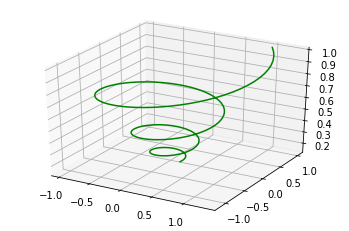

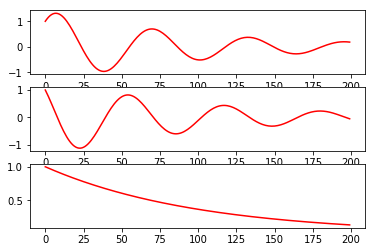

In [6]:
def dxdt(x,y,z,h=2e-2):

    K1, L1, M1 = f1(x,y,z), f2(x,y,z), f3(x,y,z)
    dx, dy, dz = h*K1/2, h*L1/2, h*M1/2
    K2, L2, M2 = f1(x+dx,y+dy, z+dz), f2(x+dx,y+dy, z+dz), f3(x+dx,y+dy, z+dz)
    dx, dy, dz = h*K2/2, h*L2/2, h*M2/2
    K3, L3, M3 = f1(x+dx,y+dy, z+dz), f2(x+dx,y+dy, z+dz), f3(x+dx,y+dy, z+dz)
    dx, dy, dz = h*K3, h*L3, h*M3
    K4, L4, M4 = f1(x+dx,y+dy, z+dz), f2(x+dx,y+dy, z+dz), f3(x+dx,y+dy, z+dz)

    dx = (K1 + 2*K2 + 2*K3 + K4)*h/6
    dy = (L1 + 2*L2 + 2*L3 + L4)*h/6
    dz = (M1 + 2*M2 + 2*M3 + M4)*h/6
    return dx, dy, dz

def trajectory(initial_point = [0.1, 0.1, 0.1], num_points=1e3, h=1e-1):
    x0, y0, z0 = initial_point[0], initial_point[1], initial_point[2]
    n = int(num_points)
    x = np.zeros([n,3])
    x[0,:] = [x0,y0,z0]

    for k in range(1,n):
        dx,dy,dz = dxdt(x[k-1,0],x[k-1,1],x[k-1,2],h)
        x[k,0] = x[k-1,0] + dx
        x[k,1] = x[k-1,1] + dy
        x[k,2] = x[k-1,2] + dz

    return x.T


def f1(x, y, z):
    return  -0.1*x + y

def f2(x, y, z):
    return  -x -0.1*y


def f3(x, y, z):
    return  - 0.1*z

# def f1(x,y,z):
#     A = 10
#     return A*(y - x)


# def f2(x,y,z):
#     B = 28;
#     return B*x - y - x*z;
    

# def f3(x,y,z):
#     C = 8/3
#     return x*y - C*z


N = 200
x = trajectory([1, 1, 1], N)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.plot(*x, 'g')
plt.show()
plt.subplot(3,1,1)
plt.plot(x[0], 'r')
plt.subplot(3,1,2)
plt.plot(x[1], 'r')
plt.subplot(3,1,3)
plt.plot(x[2], 'r')
plt.show()

# x = np.array([1, 1,1]) @ x
np.savetxt('data/lds.csv', x.T, delimiter=' ')


## multi sin

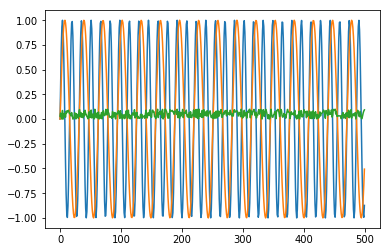

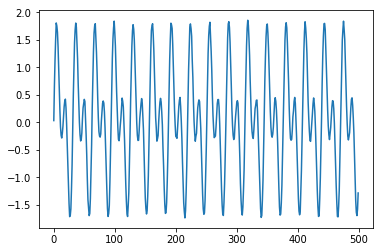

In [8]:
nt = 500
t = np.linspace(0,500,nt)
x1 = np.sin(.4*t) 
x2 = np.sin(.2*t)
x3 = np.cos(.4*t)
x4 = np.cos(.2*t)
noise = np.random.random(nt)*.1
x = x1+x2+noise
plt.plot(x1)
plt.plot(x2)
plt.plot(noise)
plt.figure()
plt.plot(x)
np.savetxt('data/multi_sin.csv', x.T, delimiter=' ')

In [9]:
def dataset_factory(data_dir, name):
    # get dataset
    if name == 'lds':
        opt, data = lds(data_dir, '{}.csv'.format(name))
    elif name == 'lorentz':
        opt, data = lorentz(data_dir,'{}.csv'.format(name))
    elif name == 'multi_sin':
        opt, data = multi_sin(data_dir,'{}.csv'.format(name))
    else:
        raise ValueError('Non dataset named `{}`.'.format(name))
   
    # split train / test
    train_data = data[:opt.nt_train]
    test_data = data[opt.nt_train:]
    return opt, (train_data, test_data)


def lds(data_dir, file='lds.csv'):
    # dataset configuration
    opt = DotDict()
    opt.nt = 200
    opt.nt_train = 100
    opt.nx = 3
    opt.periode = opt.nt
    # loading data
    data = torch.Tensor(np.genfromtxt(os.path.join(data_dir, file))).view(opt.nt, opt.nx)

    return opt, data

def lorentz(data_dir, file='lorentz.csv'):
    # dataset configuration
    opt = DotDict()
    opt.nt = 3000
    opt.nt_train = 2000
    opt.nx = 1
    opt.periode = opt.nt
    # loading data
    data = torch.Tensor(np.genfromtxt(os.path.join(data_dir, file))).view(opt.nt, opt.nx)

    return opt, data

def multi_sin(data_dir, file='sin.csv'):
    # dataset configuration
    opt = DotDict()
    opt.nt = 500
    opt.nt_train = 300
    opt.nx = 1
    opt.periode = opt.nt
    # loading data
    data = torch.Tensor(np.genfromtxt(os.path.join(data_dir, file))).view(opt.nt, opt.nx)

    return opt, data


# config

In [10]:

# parse
opt = DotDict()

opt.datadir = 'data'
opt.dataset = 'lds'
opt.outputdir = 'output_lds'
# opt.dataset = 'multi_sin'
# opt.outputdir = 'output_sin'
opt.xp = 'dfg'

opt.lr = 0.01
opt.beta1 = 0.9
opt.beta2 = 0.99
opt.eps = 1e-6
opt.wd = 1e-6
opt.wd_z = 1e-7

opt.device = 0
opt.patience = 200
opt.l2_z = .1
opt.l1_w = 0.0
opt.nz = 6
opt.pz = 1
opt.nhid = 0
opt.nlayers = 1
opt.lambd = 1
opt.activation = 'identity'
opt.batch_size = 100
opt.nepoch =5000
opt.manualSeed = random.randint(1, 10000)


# cudnn
if opt.device > -1:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(opt.device)
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

    
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.device > -1:
    torch.cuda.manual_seed_all(opt.manualSeed)


#######################################################################################################################
# Data
#######################################################################################################################
# -- load data
setup, (train_data, test_data) = dataset_factory(opt.datadir, opt.dataset)
train_data = train_data.to(device)
test_data = test_data.to(device)

for k, v in setup.items():
    opt[k] = v

# -- train inputs
t_idx = torch.arange(opt.pz,opt.nt_train, out=torch.LongTensor()).contiguous()
len(t_idx)

99

# train

In [11]:

if os.path.exists(opt.outputdir):
    shutil.rmtree(opt.outputdir)
#######################################################################################################################
# Model
#######################################################################################################################
model = DFG(opt.nx, opt.nt_train, opt.nz, opt.pz, opt.nhid, opt.nlayers,
                        opt.activation).to(device)

# model.factors.data[:,0] = torch.from_numpy(x1[:500])
# model.factors.data[:,1] = torch.from_numpy(x2[:500])
# model.factors.data[:,2] = torch.from_numpy(x3[:500])
# model.factors.data[:,3] = torch.from_numpy(x4[:500])
#######################################################################################################################
# Optimizer
#######################################################################################################################
params_E = [{'params': model.factors_parameters(), 'weight_decay': opt.wd_z}]
params_M = [{'params': model.dynamic.parameters()}, {'params': model.decoder.parameters()}]

optimizer_E = optim.Adam(params_E, lr=opt.lr, betas=(opt.beta1, opt.beta2), eps=opt.eps, weight_decay=opt.wd)
optimizer_M = optim.Adam(params_M, lr=opt.lr, betas=(opt.beta1, opt.beta2), eps=opt.eps, weight_decay=opt.wd)

if opt.patience > 0:
    lr_scheduler_E = optim.lr_scheduler.ReduceLROnPlateau(optimizer_E, patience=opt.patience)
    lr_scheduler_M = optim.lr_scheduler.ReduceLROnPlateau(optimizer_M, patience=opt.patience)


#######################################################################################################################
# Logs
#######################################################################################################################
logger = Logger(opt.outputdir, opt.xp, opt.nt_train)
with open(os.path.join(opt.outputdir, opt.xp, 'config.json'), 'w') as f:
    json.dump(opt, f, sort_keys=True, indent=4)


#######################################################################################################################
# Training
#######################################################################################################################


from tqdm.notebook import tqdm


def EMstep(): 
    lr = opt.lr
    E_step = True
    
    pb = tqdm(range(opt.nepoch))
    for e in pb:
        
#         E_step = True if np.random.random() < 0.5 else False
        E_step = not E_step
#         if E_step:
#             optimizer = optim.Adam(params_E, lr=opt.lr, betas=(opt.beta1, opt.beta2), eps=opt.eps, weight_decay=opt.wd)
#         else:
#             optimizer = optim.Adam(params_M, lr=opt.lr, betas=(opt.beta1, opt.beta2), eps=opt.eps, weight_decay=opt.wd)

#         if opt.patience > 0:
#             lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=opt.patience)


        optimizer = optimizer_E if E_step else optimizer_M
        lr_scheduler = lr_scheduler_E if E_step else lr_scheduler_M

        # ------------------------ Train ------------------------
        model.train()
        # --- decoder ---

        idx_perm = torch.randperm(len(t_idx)).to(device)
#         print(idx_perm)
        batches = idx_perm.split(opt.batch_size)
        logs_train = defaultdict(float)
        for i, batch in enumerate(batches):

            optimizer.zero_grad()
            # data
#             print(batch)
            input_t = t_idx[batch]
            x_target = train_data[input_t]
            # closure
            x_rec = model.dec_closure(input_t)


            mse_dec = F.mse_loss(x_rec, x_target)
            # backward
#             mse_dec.backward()
            # step
#             optimizer.step()
            # log
            logger.log('train_iter.mse_dec', mse_dec.item())
            logs_train['mse_dec'] += mse_dec.item() * len(batch)

        # --- dynamic ---

#         idx_perm = torch.randperm(opt.nt_train-1).to(device)
#         batches = idx_perm.split(opt.batch_size)
#         for i, batch in enumerate(batches):
#             optimizer.zero_grad()
            # data
#             input_t = t_idx[batch]

            # closure
            z_inf = model.factors[input_t]

            z_pred = model.dyn_closure(input_t)

            # loss
            mse_dyn = z_pred.sub(z_inf).pow(2).mean()
            loss_dyn = mse_dyn * opt.lambd

            l2_regularization = torch.tensor(0.0).to(device)
            if opt.l2_z > 0:
                l2_regularization = opt.l2_z * model.factors[input_t - 1].sub(model.factors[input_t]).pow(2).mean()
            
            l1_regularization = torch.tensor(0.0).to(device)
            if opt.l1_w > 0:
                for param in model.dynamic.parameters():
                    l1_regularization += torch.norm(param, 1)
                l1_regularization = opt.l1_w * l1_regularization
            
            total_loss = loss_dyn + mse_dec + l1_regularization + l2_regularization
            # backward
            total_loss.backward()
            # step
            optimizer.step()

            # log
            logger.log('train_iter.mse_dyn', mse_dyn.item())
            logs_train['mse_dyn'] += mse_dyn.item() * len(batch)
            logs_train['loss_dyn'] += loss_dyn.item() * len(batch)

#         # --- logs ---
        logs_train['mse_dec'] /= opt.nt_train
        logs_train['mse_dyn'] /= opt.nt_train
        logs_train['loss_dyn'] /= opt.nt_train
        logs_train['loss'] = logs_train['mse_dec'] + logs_train['loss_dyn']
        logger.log('train_epoch', logs_train)

        # ------------------------ Test ------------------------

        model.eval()
        with torch.no_grad():
            x_pred, _ = model.generate(opt.nt - opt.nt_train)
            score_ts = rmse(x_pred, test_data, reduce=False)
            score = rmse(x_pred, test_data)

        logger.log('test_epoch.rmse', score)
        logger.log('test_epoch.ts', {t: {'rmse': scr.item()} for t, scr in enumerate(score_ts)})

        # checkpoint
        logger.log('train_epoch.lr', lr)
        pb.set_postfix(loss=logs_train['loss'], rmse_test=score, lr=lr)
        logger.checkpoint(model)

        # schedule lr
        if opt.patience > 0:  # and score < 1
            lr_scheduler.step(score)
        
        lr = optimizer.param_groups[0]['lr'] \
#             if not E_step else 1
        if lr <= 1e-5:
            break


EMstep()

logger.save(model)



In [12]:
list(model.dynamic.parameters())

[Parameter containing:
 tensor([[ 0.3347,  0.1942, -0.3871, -0.6459,  0.2931,  0.5534],
         [-0.2971,  0.8700, -0.0357, -0.2774,  0.0627,  0.0751],
         [-0.2836, -0.1025,  0.9232, -0.2456, -0.0091,  0.1385],
         [-0.4263,  0.0570, -0.2197,  0.5914,  0.0970,  0.2079],
         [-0.0917, -0.2381,  0.1626, -0.0113,  0.9038, -0.0593],
         [ 0.8110,  0.0070,  0.4391,  0.8845, -0.3076,  0.4262]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.1344,  0.0687,  0.0694,  0.0897,  0.0272, -0.1939], device='cuda:0',
        requires_grad=True)]

# show results

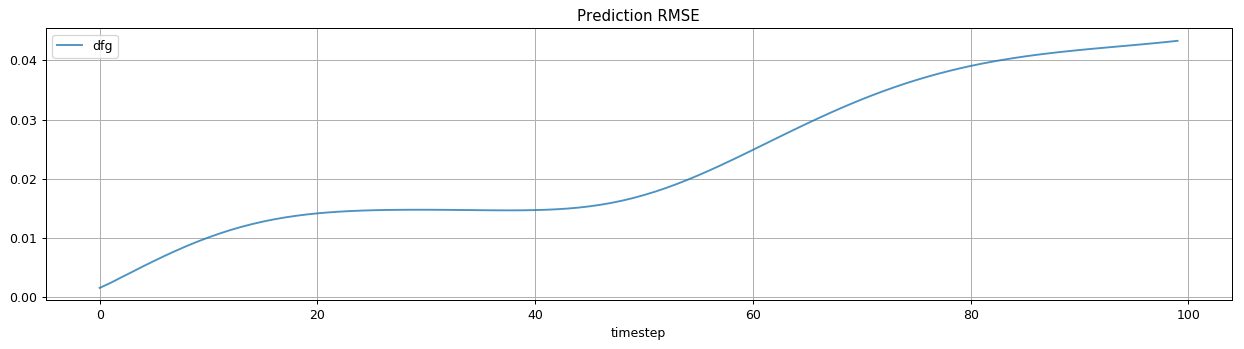

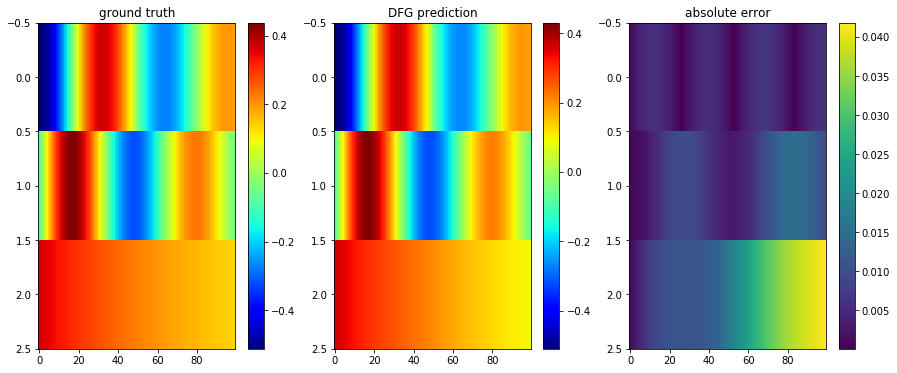

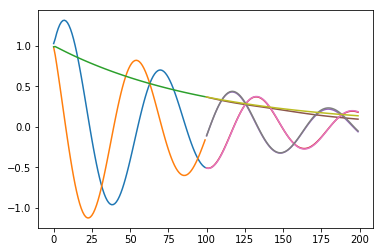

In [13]:

"""
result
"""

model.eval()
with torch.no_grad():
    prediction, _ = model.generate(opt.nt - opt.nt_train)
    mse = rmse(prediction, test_data)
# print('RMSE :\t'.format( mse))

import matplotlib.pyplot as plt
plt.figure('Test plots', figsize=(17, 4), dpi=90)

with open(os.path.join(opt.outputdir, opt.xp, 'logs.json'), 'r') as f:
    logs = json.load(f)

plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(100)], label=opt.xp, alpha=0.8)
plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

plt.figure('Results',figsize=(15,6))

plt.subplot(1, 3, 1)
plt.imshow(test_data.squeeze().cpu().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')


plt.subplot(1, 3, 2)
plt.imshow(prediction.squeeze().cpu().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('{} prediction'.format('DFG'))

plt.subplot(1, 3, 3)
plt.imshow(test_data.sub(prediction).abs().cpu().numpy().T, aspect='auto')
plt.colorbar()
plt.title('absolute error')

plt.figure()
plt.plot(model.decode_z(model.factors).squeeze().detach().cpu().numpy())
plt.plot(range(opt.nt_train,opt.nt),prediction.squeeze().detach().cpu().numpy())
plt.plot(range(opt.nt_train,opt.nt),test_data.squeeze().cpu().numpy())
plt.show() 

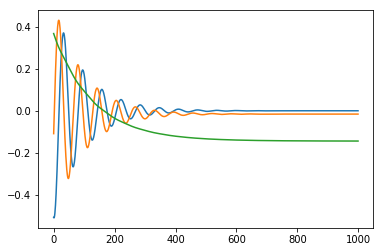

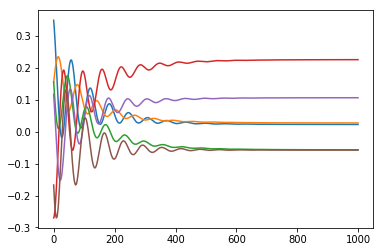

In [17]:
with torch.no_grad():
    pred, hid = model.generate(1000)

pred = pred.squeeze().detach().cpu().numpy()
hid  = hid.squeeze().detach().cpu().numpy()
plt.plot(pred)

plt.figure()
plt.plot(hid)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# plt.plot(*pred.T, 'g')
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# plt.plot(*hid.T, 'g')
# plt.show()

In [18]:
model.decoder.weight

Parameter containing:
tensor([[-0.6742,  0.3680,  0.5771,  0.7177, -0.7157,  0.8434],
        [-0.5937,  0.7258, -0.5000, -0.0519, -0.8537, -0.8991],
        [ 0.4192,  0.8659,  0.9099, -0.1913, -0.7001,  0.1485]],
       device='cuda:0', requires_grad=True)

# 从隐状态重建训练集

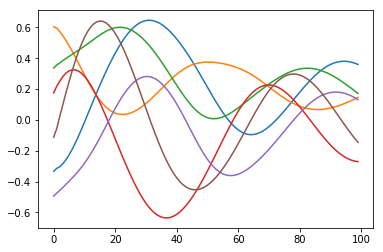

In [20]:
plt.plot(model.factors.cpu().detach().numpy())

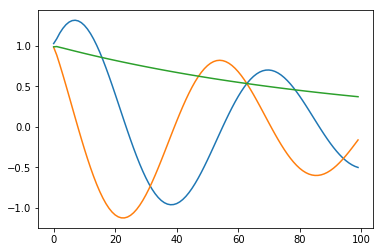

In [21]:
plt.plot(model.decode_z(model.factors).cpu().detach().numpy())

In [25]:
model.decoder.weight

Parameter containing:
tensor([[-0.6742,  0.3680,  0.5771,  0.7177, -0.7157,  0.8434],
        [-0.5937,  0.7258, -0.5000, -0.0519, -0.8537, -0.8991],
        [ 0.4192,  0.8659,  0.9099, -0.1913, -0.7001,  0.1485]],
       device='cuda:0', requires_grad=True)